# ML classification

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
%matplotlib inline

In [3]:
df=pd.read_csv('Data\df_ML.csv')

In [4]:
df.head(2)

,player,name,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,...,position_Defender Centre-Back,position_Defender Left-Back,position_Defender Right-Back,position_Goalkeeper,position_midfield,position_midfield-AttackingMidfield,position_midfield-CentralMidfield,position_midfield-DefensiveMidfield,position_midfield-LeftMidfield,position_midfield-RightMidfield
0,/raphael-varane/profil/spieler/164770,Raphaël Varane,191.0,30.0,63,0.017889,0.017889,0.053667,0.0000,0.0,...,True,False,False,False,False,False,False,False,False,False
1,/harry-maguire/profil/spieler/177907,Harry Maguire,194.0,30.0,68,0.037799,0.000000,0.302394,0.0189,0.0,...,True,False,False,False,False,False,False,False,False,False


In [6]:
# Calculate the 35th and 75th percentiles of the current_value
p35 = df['current_value'].quantile(0.35)
p75 = df['current_value'].quantile(0.75)

# Function to categorize current_value
def categorize_value(value):
    if value < p35:
        return 'Cheap value'
    elif value < p75:
        return 'Good value'
    else:
        return 'High value'

# Apply the function to create a new column
df['current_value_category'] = df['current_value'].apply(categorize_value)


In [7]:
# drop current_value build ML classification
df.drop('current_value', axis=1, inplace=True)

In [8]:
# Verify the distribution of the new categories
print(df['current_value_category'].value_counts())

current_value_category
Good value     3888
Cheap value    2908
High value     2269
Name: count, dtype: int64


In [9]:
encoder = LabelEncoder()
df['current_value_category_encoded'] = encoder.fit_transform(df['current_value_category'])

In [10]:
df['current_value_category_encoded'].value_counts()

current_value_category_encoded
1    3888
0    2908
2    2269
Name: count, dtype: int64

### Feature selection

In [11]:
correlation = df.corr(numeric_only=True)
print(correlation['current_value_category_encoded'].sort_values(ascending=False))

current_value_category_encoded    1.000000
appearance                        0.493405
highest_value                     0.483106
minutes played                    0.464417
games_injured                     0.294818
                                    ...   
team_Marumo Gallants FC          -0.071075
position_Attack                  -0.083270
position_midfield                -0.093656
goals conceded                   -0.140201
position_Goalkeeper              -0.193982
Name: current_value_category_encoded, Length: 408, dtype: float64


In [12]:
# Set the correlation threshold
threshold = 0.1  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['current_value_category_encoded']) > threshold]['current_value_category_encoded'].index
selected_features

Index(['appearance', 'goals', 'assists', 'goals conceded', 'minutes played',
       'days_injured', 'games_injured', 'award', 'highest_value',
       'position_encoded', 'position_Goalkeeper',
       'current_value_category_encoded'],
      dtype='object')

In [ ]:
df = df[selected_features]
df.head(2)

,appearance,goals,assists,goals conceded,minutes played,days_injured,games_injured,award,highest_value,position_encoded,position_Goalkeeper,current_value_category_encoded
0,63,0.017889,0.017889,0.0,5031,238,51,21,80000000,2,False,2
1,68,0.037799,0.000000,0.0,4762,148,27,1,70000000,2,False,2
2,70,0.000000,0.032901,0.0,5471,95,19,10,35000000,2,False,2
3,34,0.000000,0.000000,0.0,2758,47,13,0,2000000,2,False,1
4,34,0.000000,0.033507,0.0,2686,175,28,1,12000000,2,False,2


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9065 entries, 0 to 9064
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   appearance                      9065 non-null   int64  
 1   goals                           9065 non-null   float64
 2   assists                         9065 non-null   float64
 3   goals conceded                  9065 non-null   float64
 4   minutes played                  9065 non-null   int64  
 5   days_injured                    9065 non-null   int64  
 6   games_injured                   9065 non-null   int64  
 7   award                           9065 non-null   int64  
 8   highest_value                   9065 non-null   int64  
 9   position_encoded                9065 non-null   int64  
 10  position_Goalkeeper             9065 non-null   bool   
 11  current_value_category_encoded  9065 non-null   int64  
dtypes: bool(1), float64(3), int64(8)
m

## Models

### spilt train and test data

In [80]:
X = df.drop(['current_value_category_encoded'], axis=1)
y = df['current_value_category_encoded']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=99)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [81]:
X.shape ,y.shape

((9065, 11), (9065,))

### LogisticRegression

In [24]:
model = LogisticRegression()

#### Train the Model

In [25]:
# Fit the model on the training data
model.fit(X_train_scaled, y_train)

LogisticRegression()

#### Test the Model

In [26]:
# Predict and evaluate the model
y_pred_test = model.predict(X_test_scaled)

#### Interpretation of the Model

In [27]:
# Each row of the model.coef_ matrix tells you how each feature affects being in the corresponding class versus any other class
coeff_df = pd.DataFrame(model.coef_[2],X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
appearance,-0.006057
goals,0.069601
assists,0.072644
goals conceded,-0.213670
minutes played,0.448463
days_injured,0.020506
games_injured,-0.116520
award,-0.329413
highest_value,5.238769
position_encoded,0.001050


In [28]:
model.coef_

array([[ 1.63691596e-02, -1.70605640e-02, -8.46174103e-02,
         9.29609124e-02, -5.43559651e-01, -3.95739481e-03,
        -2.59545772e-02,  1.74616818e-01, -6.89739934e+00,
        -5.97598463e-02,  9.07308572e-02],
       [-1.03119493e-02, -5.25400566e-02,  1.19730127e-02,
         1.20708627e-01,  9.50967639e-02, -1.65490801e-02,
         1.42474386e-01,  1.54796564e-01,  1.65863035e+00,
         5.87097589e-02, -9.46483059e-02],
       [-6.05721037e-03,  6.96006207e-02,  7.26443976e-02,
        -2.13669539e-01,  4.48462887e-01,  2.05064749e-02,
        -1.16519809e-01, -3.29413382e-01,  5.23876898e+00,
         1.05008743e-03,  3.91744870e-03]])

#### Evaluating the Model


##### Accuracy

In [31]:
# Train score
y_pred_train = model.predict(X_train_scaled)
accuracy_Train = accuracy_score(y_train, y_pred_train)
print(f"Train score: {accuracy_Train}")

Train score: 0.7155267512410369


In [32]:
# Test score
accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_test
print(f"Test score: {accuracy_test}")

Test score: 0.7115278543849972


##### Confusion matrix

In [33]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
conf_matrix

array([[459, 117,   4],
       [207, 539,  40],
       [  0, 155, 292]])

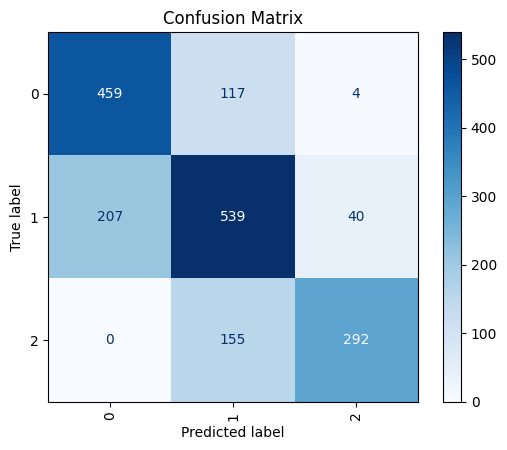

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test,
                                        display_labels=model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

##### precision

In [35]:
# Train score
precision_train = precision_score(y_train, y_pred_train, average='macro')
print(f"Precision in train: {precision_train:.2f}")

# Test score
precision_test = precision_score(y_test, y_pred_test, average='macro')
print(f"Precision in test: {precision_test:.2f}")

Precision in train: 0.75
Precision in test: 0.74


##### Recall

In [36]:
# Train score
recall_train = recall_score(y_train, y_pred_train, average='macro')
print(f"Recall in train: {recall_train:.2f}")

# Test score
recall_test = recall_score(y_test, y_pred_test, average='macro')
print(f"Recall in test: {recall_test:.2f}")

Recall in train: 0.71
Recall in test: 0.71


##### F1 SCORE

In [37]:
# Train score
f1_train = f1_score(y_train, y_pred_train, average='macro')
print(f"f1-score in train: {f1_train:.2f}")

# Test score
f1_test = precision_score(y_test, y_pred_test, average='macro')
print(f"f1-score in test: {f1_test:.2f}")

f1-score in train: 0.72
f1-score in test: 0.74


#### Report Classification 

In [38]:
from sklearn.metrics import classification_report

print('Train report: ')
print(classification_report(y_train, y_pred_train))

print('Test report: ')
print(classification_report(y_test, y_pred_test))

Train report: 
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      2328
           1       0.66      0.72      0.69      3102
           2       0.86      0.62      0.72      1822

    accuracy                           0.72      7252
   macro avg       0.75      0.71      0.72      7252
weighted avg       0.73      0.72      0.72      7252

Test report: 
              precision    recall  f1-score   support

           0       0.69      0.79      0.74       580
           1       0.66      0.69      0.68       786
           2       0.87      0.65      0.75       447

    accuracy                           0.71      1813
   macro avg       0.74      0.71      0.72      1813
weighted avg       0.72      0.71      0.71      1813



### Decision Trees & Random Forest

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#### Build the model


In [42]:
dt_classifier = DecisionTreeClassifier()
rf_classifier = RandomForestClassifier()

In [43]:
param_grid = {
    'max_depth': [4, 5, 6, 7, 8],   # adjust tree depth
    'n_estimators':[35, 40, 50, 60]      # adjust num trees to build before taking the maximum voting or averages of predictions
}
grid_search = GridSearchCV(estimator=rf_classifier,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro', 
                           verbose=1)

#### Train model

In [44]:
# Fit the model on the training data
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [45]:
rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [46]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': [35, 40, 50, 60]},
             scoring='f1_macro', verbose=1)

In [47]:
grid_search.best_params_

{'max_depth': 8, 'n_estimators': 35}

In [48]:
best_model = grid_search.best_estimator_

#### Test the Model

In [49]:
# Predict and evaluate the model
y_pred_dt = dt_classifier.predict(X_test)
y_pred_rf = rf_classifier.predict(X_test)
y_pred_rf_g = best_model.predict(X_test)

#### Evaluating the Model


##### Accuracy

In [50]:
# Evaluate train set dt model
y_pred_train_dt = dt_classifier.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_train_dt)
accuracy

0.9998621070049641

In [51]:
# Evaluate test set dt model
accuracy = accuracy_score(y_test, y_pred_dt)
accuracy

0.7633756205184776

In [52]:
# Evaluate train set dt model
y_pred_train_rf = rf_classifier.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_train_rf)
accuracy

0.9998621070049641

In [53]:
# Evaluate test set rf model
accuracy = accuracy_score(y_test, y_pred_rf)
accuracy

0.8306674020959736

In [54]:
y_pred_train_rf_g = best_model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_train_rf_g)
accuracy

0.8495587424158852

In [55]:
accuracy = accuracy_score(y_test, y_pred_rf_g)
accuracy

0.8284611141753999

##### Confusion matrix


In [56]:
conf_matrix = confusion_matrix(y_test, y_pred_rf_g)
conf_matrix

array([[424, 141,  15],
       [  3, 686,  97],
       [  0,  55, 392]])

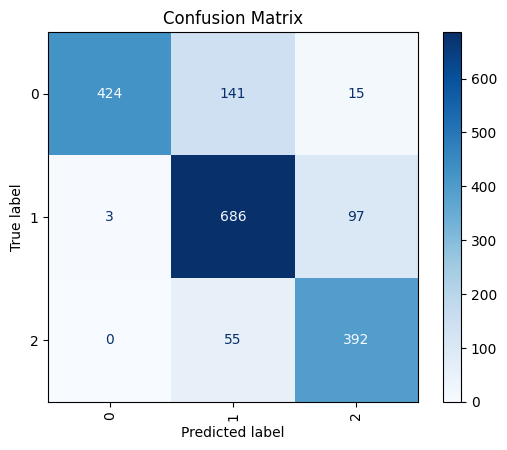

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_g,
                                        display_labels=best_model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

##### Precision

In [58]:
precision = precision_score(y_test, y_pred_rf_g, average='macro')
print(f"Precision: {precision:.2f}")

Precision: 0.85


##### Recall

In [59]:
recall = recall_score(y_test, y_pred_rf_g, average='macro')
print(f"Recall: {recall:.2f}")

Recall: 0.83


##### F1 Score

In [60]:
# Calculate F1 Score
f1 = f1_score(y_test, y_pred_rf_g, average='macro')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.83


##### classification report

In [61]:
from sklearn.metrics import classification_report

print('Train report: ')
print(classification_report(y_train, y_pred_train_rf_g))

print('Test report: ')
print(classification_report(y_test, y_pred_rf_g))

Train report: 
              precision    recall  f1-score   support

           0       1.00      0.74      0.85      2328
           1       0.79      0.89      0.84      3102
           2       0.82      0.92      0.87      1822

    accuracy                           0.85      7252
   macro avg       0.87      0.85      0.85      7252
weighted avg       0.87      0.85      0.85      7252

Test report: 
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       580
           1       0.78      0.87      0.82       786
           2       0.78      0.88      0.82       447

    accuracy                           0.83      1813
   macro avg       0.85      0.83      0.83      1813
weighted avg       0.85      0.83      0.83      1813



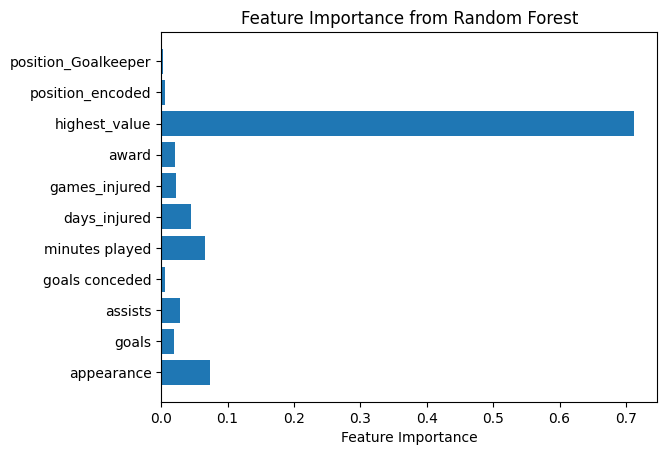

In [62]:
# Feature importance from Random Forest
feature_importances = best_model.feature_importances_
plt.barh(X.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest')
plt.show()

### SVM

In [63]:
from sklearn.svm import SVC

#### Build the model
 

In [66]:
svm_classifier = SVC()

In [67]:
param_grid = {
    'kernel': [
             # 'linear',
               'rbf',
             # 'poly'
              ],   # Regularization strength
    'C':[1, 2, 5, 10, 15, 20, 25],
    'gamma': [1,2,6]
}
grid_search = GridSearchCV(estimator=svm_classifier,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro', 
                           verbose=1)

#### Train the Model


In [68]:
# Fit the model on the training data
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 2, 5, 10, 15, 20, 25], 'gamma': [1, 2, 6],
                         'kernel': ['rbf']},
             scoring='f1_macro', verbose=1)

In [69]:
print(grid_search.best_params_)
model = grid_search.best_estimator_

{'C': 5, 'gamma': 1, 'kernel': 'rbf'}


#### Test the Model


In [70]:
# Predict and evaluate the model
y_pred_test = model.predict(X_test_scaled)

#### Evaluating the Model


##### Accuracy


In [71]:
# Train score
y_pred_train = model.predict(X_train_scaled)
accuracy_Train = accuracy_score(y_train, y_pred_train)
print(f"Train score: {accuracy_Train}")

Train score: 0.9129895201323773


In [ ]:
# Test score
accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_test
print(f"Test score: {accuracy_test}")

##### Confusion matrix

In [72]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
conf_matrix

array([[412, 152,  16],
       [159, 530,  97],
       [  3,  92, 352]])

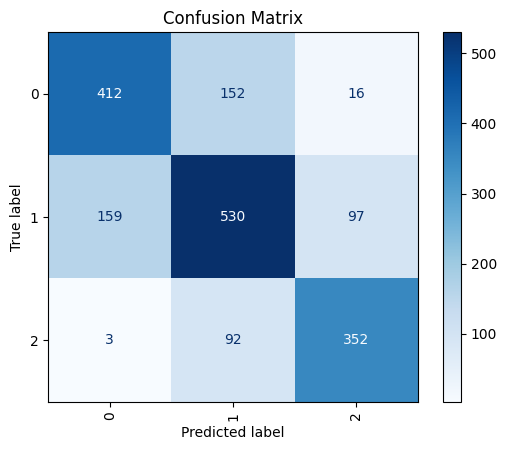

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test,
                                        display_labels=model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

##### Precision


In [74]:
# Train score
precision_train = precision_score(y_train, y_pred_train, average='macro')
print(f"Precision in train: {precision_train:.2f}")

Precision in train: 0.92


In [75]:
# Test score
precision_test = precision_score(y_test, y_pred_test, average='macro')
print(f"Precision in test: {precision_test:.2f}")

Precision in test: 0.72


##### Recall

In [76]:
# Train score
recall_train = recall_score(y_train, y_pred_train, average='macro')
print(f"Recall in train: {recall_train:.2f}")

# Test score
recall_test = recall_score(y_test, y_pred_test, average='macro')
print(f"Recall in test: {recall_test:.2f}")

Recall in train: 0.92
Recall in test: 0.72


##### F1-Score


In [78]:
# Train score
f1_train = f1_score(y_train, y_pred_train, average='macro')
print(f"f1-score in train: {f1_train:.2f}")

# Test score
f1_test = precision_score(y_test, y_pred_test, average='macro')
print(f"f1-score in test: {f1_test:.2f}")


f1-score in train: 0.92
f1-score in test: 0.72


##### Classification report


In [79]:
from sklearn.metrics import classification_report

print('Train report: ')
print(classification_report(y_train, y_pred_train))

print('Test report: ')
print(classification_report(y_test, y_pred_test))

Train report: 
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      2328
           1       0.90      0.90      0.90      3102
           2       0.96      0.96      0.96      1822

    accuracy                           0.91      7252
   macro avg       0.92      0.92      0.92      7252
weighted avg       0.91      0.91      0.91      7252

Test report: 
              precision    recall  f1-score   support

           0       0.72      0.71      0.71       580
           1       0.68      0.67      0.68       786
           2       0.76      0.79      0.77       447

    accuracy                           0.71      1813
   macro avg       0.72      0.72      0.72      1813
weighted avg       0.71      0.71      0.71      1813



### Knn

In [82]:
from sklearn.neighbors import KNeighborsClassifier

#### Build the model


In [83]:
model = KNeighborsClassifier()

In [84]:
param_grid = {
    'n_neighbors': [3, 5,  7, 9, 11,13,15,17]
}
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro', 
                           verbose=1)

#### Train the Model


In [85]:
# Fit the model on the training data
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17]},
             scoring='f1_macro', verbose=1)

In [86]:
print(grid_search.best_params_)
# Fit the model on the training data
model = grid_search.best_estimator_

{'n_neighbors': 13}


#### Test the Model

In [ ]:
# Predict and evaluate the model
y_pred_test = model.predict(X_test_scaled)

#### Evaluating the Model


##### Accuracy

In [88]:
# Train score
y_pred_train = model.predict(X_train_scaled)
accuracy_Train = accuracy_score(y_train, y_pred_train)
print(f"Train score: {accuracy_Train}")

# Test score
accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_test
print(f"Test score: {accuracy_test}")

Train score: 0.6959459459459459
Test score: 0.6453392167677882


##### Confusion matrix


In [89]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
conf_matrix

array([[368, 207,   5],
       [205, 536,  45],
       [ 18, 163, 266]])

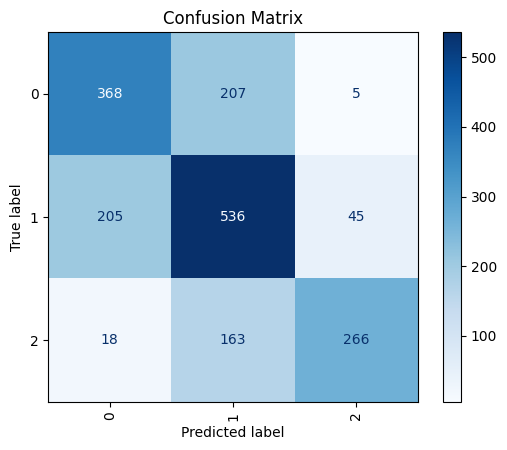

In [90]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test,
                                        display_labels=model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

##### Precision

In [91]:
# Train score
precision_train = precision_score(y_train, y_pred_train, average='macro')
print(f"Precision in train: {precision_train:.2f}")

# Test score
precision_test = precision_score(y_test, y_pred_test, average='macro')
print(f"Precision in test: {precision_test:.2f}")

Precision in train: 0.73
Precision in test: 0.69


##### Recall

In [93]:
# Train score
recall_train = recall_score(y_train, y_pred_train, average='macro')
print(f"Recall in train: {recall_train:.2f}")

# Test score
recall_test = recall_score(y_test, y_pred_test, average='macro')
print(f"Recall in test: {recall_test:.2f}")


Recall in train: 0.68
Recall in test: 0.64


##### F1-Score

In [94]:
# Train score
f1_train = f1_score(y_train, y_pred_train, average='macro')
print(f"f1-score in train: {f1_train:.2f}")

# Test score
f1_test = precision_score(y_test, y_pred_test, average='macro')
print(f"f1-score in test: {f1_test:.2f}")

f1-score in train: 0.70
f1-score in test: 0.69


##### Classification report

In [95]:
from sklearn.metrics import classification_report

print('Train report: ')
print(classification_report(y_train, y_pred_train))

print('Test report: ')
print(classification_report(y_test, y_pred_test))

Train report: 
              precision    recall  f1-score   support

           0       0.71      0.69      0.70      2328
           1       0.64      0.76      0.69      3102
           2       0.85      0.60      0.70      1822

    accuracy                           0.70      7252
   macro avg       0.73      0.68      0.70      7252
weighted avg       0.71      0.70      0.70      7252

Test report: 
              precision    recall  f1-score   support

           0       0.62      0.63      0.63       580
           1       0.59      0.68      0.63       786
           2       0.84      0.60      0.70       447

    accuracy                           0.65      1813
   macro avg       0.69      0.64      0.65      1813
weighted avg       0.66      0.65      0.65      1813

